In [1]:
# === Step 1: Upload and Read Excel File in Colab ===

from google.colab import files
import pandas as pd

# Upload your Excel file (choose file when prompted)
uploaded = files.upload()

# Get uploaded file name automatically
file_name = list(uploaded.keys())[0]

# Read Excel file into DataFrame
df = pd.read_excel(file_name)

# Show quick info and preview
print("✅ File loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")
display(df.head())

# Extract the discharge column (assuming it's named 'y')
y_series = df['y']

print("\n📈 First 10 discharge values:")
print(y_series.head(10))


Saving pressure (1) (1).xlsx to pressure (1) (1).xlsx
✅ File loaded successfully!
Shape: (313, 1)
Columns: ['y']



,y
0,68.70
1,66.17
2,87.85
3,231.00
4,207.80



📈 First 10 discharge values:
0     68.70
1     66.17
2     87.85
3    231.00
4    207.80
5    210.60
6    613.70
7    550.00
8    742.60
9    457.80
Name: y, dtype: float64


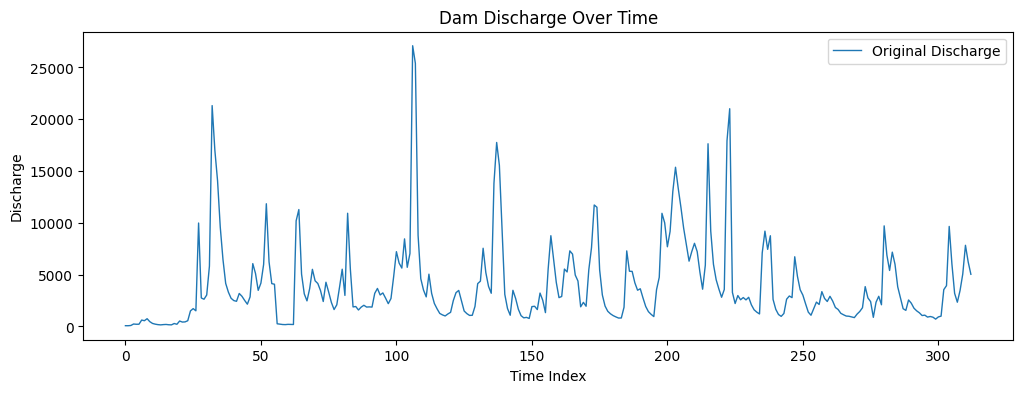

✅ Dataset Overview
                  y
count    313.000000
mean    4037.354058
std     4089.314410
min       66.170000
25%     1459.000000
50%     2778.000000
75%     5310.000000
max    27093.000000

Missing values: 0


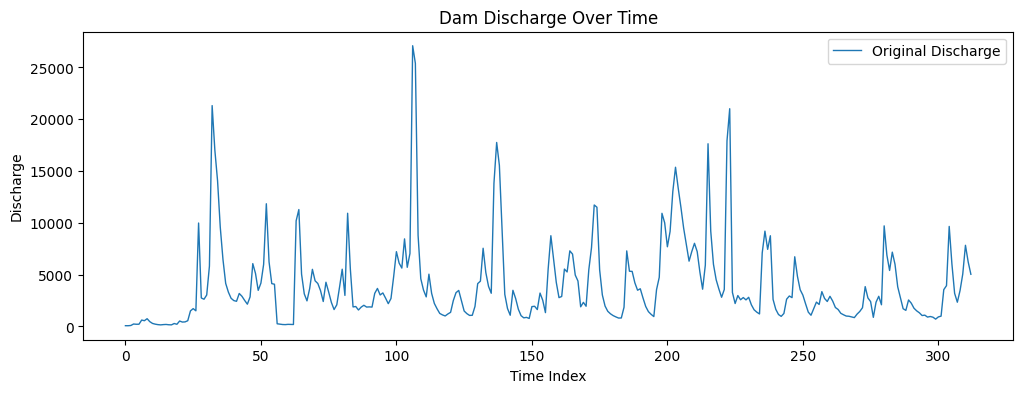


🔍 Outliers detected: 19


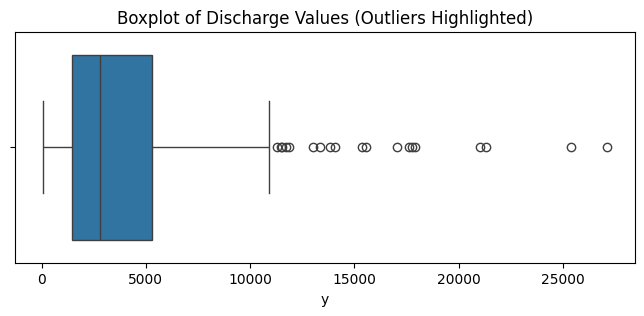

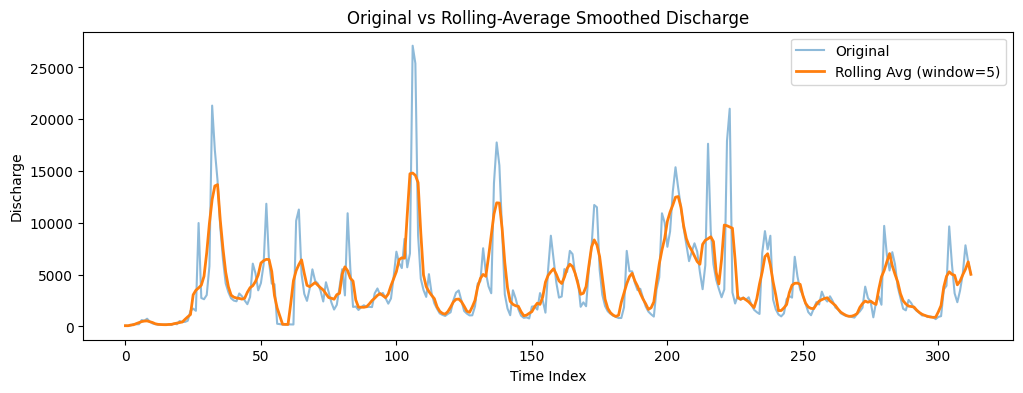


✅ Outliers replaced with rolling average values.
Dataset ready for KAN modeling.
Total points: 313

🔍 Outliers detected: 11


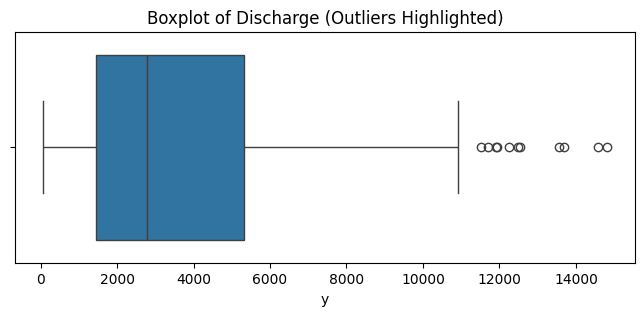

In [2]:
# === Step 2: EDA and Data Interpretation for Dam Discharge ===

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure numeric
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Missing value handling
df['y'] = df['y'].interpolate(method='linear')

# Plot original
plt.figure(figsize=(12,4))
plt.plot(df['y'], label='Original Discharge', linewidth=1)
plt.title('Dam Discharge Over Time')
plt.xlabel('Time Index')
plt.ylabel('Discharge')
plt.legend()
plt.show()

# Outlier detection
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
# === Step 2: EDA and Data Interpretation for Dam Discharge ===

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure we're working with a numeric series
y = pd.to_numeric(df['y'], errors='coerce')
df['y'] = y

# --- Basic Info ---
print("✅ Dataset Overview")
print(df.describe())
print("\nMissing values:", df['y'].isna().sum())

# --- Fill or drop missing values ---
df['y'] = df['y'].interpolate(method='linear')

# --- Plot Original Data ---
plt.figure(figsize=(12,4))
plt.plot(df['y'], label='Original Discharge', linewidth=1)
plt.title('Dam Discharge Over Time')
plt.xlabel('Time Index')
plt.ylabel('Discharge')
plt.legend()
plt.show()

# --- Outlier Detection (IQR method) ---
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['y'] < lower_bound) | (df['y'] > upper_bound)]
print(f"\n🔍 Outliers detected: {len(outliers)}")

# --- Plot Boxplot for Outlier View ---
plt.figure(figsize=(8,3))
sns.boxplot(x=df['y'])
plt.title('Boxplot of Discharge Values (Outliers Highlighted)')
plt.show()

# --- Rolling Average Smoothing ---
window_size = 5  # you can tune this (3, 5, 7...)
df['y_smooth'] = df['y'].rolling(window=window_size, center=True).mean()
df['y_smooth'] = df['y_smooth'].fillna(df['y'])  # fill edges

# --- Compare Original vs Smoothed ---
plt.figure(figsize=(12,4))
plt.plot(df['y'], label='Original', alpha=0.5)
plt.plot(df['y_smooth'], label=f'Rolling Avg (window={window_size})', linewidth=2)
plt.title('Original vs Rolling-Average Smoothed Discharge')
plt.xlabel('Time Index')
plt.ylabel('Discharge')
plt.legend()
plt.show()

# --- Outlier Treatment: Replace with Smoothed Values ---
df.loc[(df['y'] < lower_bound) | (df['y'] > upper_bound), 'y'] = df['y_smooth']

print("\n✅ Outliers replaced with rolling average values.")
print(f"Dataset ready for KAN modeling.\nTotal points: {len(df)}")

outliers = df[(df['y'] < lower) | (df['y'] > upper)]
print(f"\n🔍 Outliers detected: {len(outliers)}")

# Boxplot
plt.figure(figsize=(8,3))
sns.boxplot(x=df['y'])
plt.title("Boxplot of Discharge (Outliers Highlighted)")
plt.show()


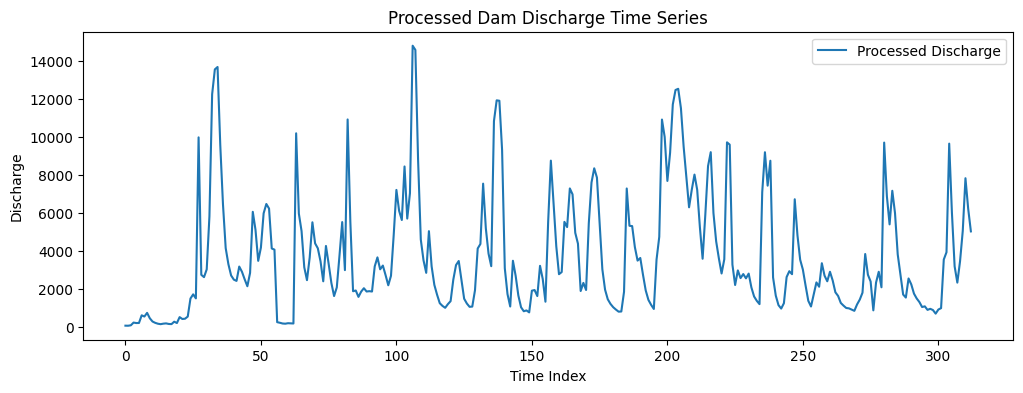

📊 Augmented Dickey-Fuller (ADF) Test Results:
ADF Statistic: -6.9537
p-value: 0.0000
Critical Value (1%): -3.4516
Critical Value (5%): -2.8709
Critical Value (10%): -2.5717

✅ Series is Stationary (no trend remains)


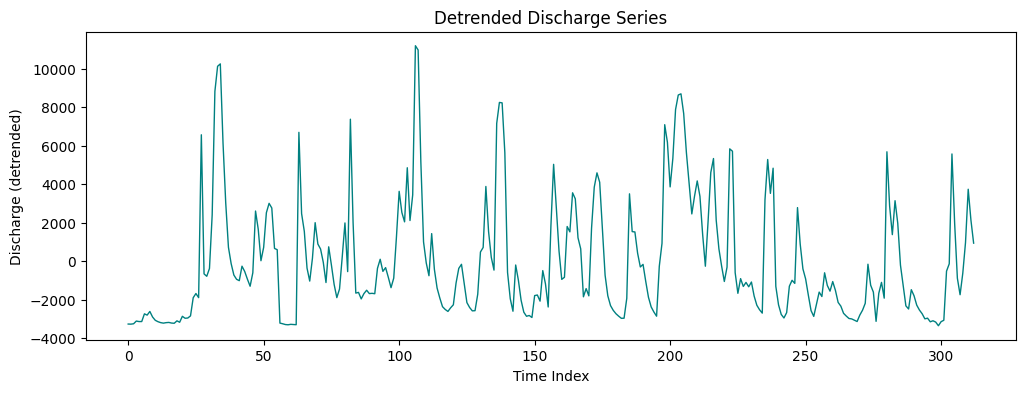

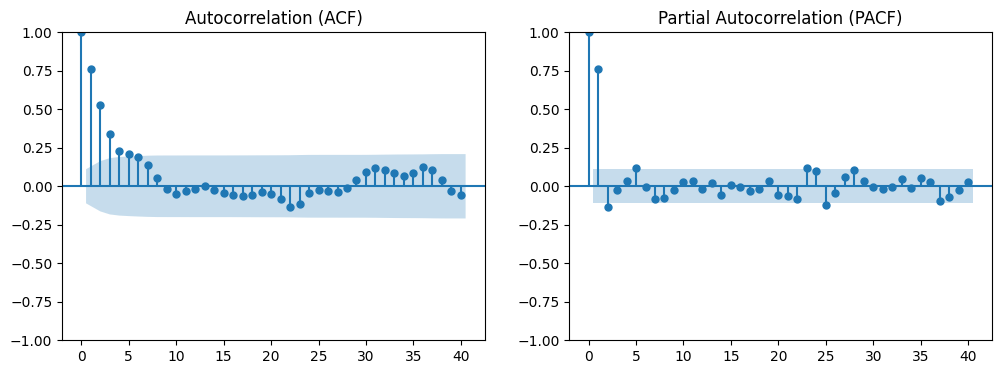


🔊 Average noise level (std deviation): 1545.60

📋 Summary of Findings:
- Data length: 313 points
- Outliers handled via rolling average
- Stationary: Yes
- Average noise (std): 1545.60


In [3]:
# === Step 3: Stationarity, Trend, and Noise Analysis ===

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend

# --- Visualize Time Series ---
plt.figure(figsize=(12,4))
plt.plot(df['y'], label='Processed Discharge', linewidth=1.5)
plt.title('Processed Dam Discharge Time Series')
plt.xlabel('Time Index')
plt.ylabel('Discharge')
plt.legend()
plt.show()

# --- ADF Test for Stationarity ---
print("📊 Augmented Dickey-Fuller (ADF) Test Results:")
adf_result = adfuller(df['y'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

if adf_result[1] <= 0.05:
    print("\n✅ Series is Stationary (no trend remains)")
else:
    print("\n⚠️ Series is Non-Stationary (trend or drift detected)")

# --- Detrend if necessary ---
df['y_detrended'] = detrend(df['y'])
plt.figure(figsize=(12,4))
plt.plot(df['y_detrended'], color='teal', linewidth=1)
plt.title('Detrended Discharge Series')
plt.xlabel('Time Index')
plt.ylabel('Discharge (detrended)')
plt.show()

# --- Autocorrelation Analysis ---
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df['y'], ax=ax[0], lags=40)
plot_pacf(df['y'], ax=ax[1], lags=40)
ax[0].set_title('Autocorrelation (ACF)')
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.show()

# --- Noise Level (Standard Deviation of residuals) ---
df['residuals'] = df['y'] - df['y_smooth']
noise_std = np.std(df['residuals'])
print(f"\n🔊 Average noise level (std deviation): {noise_std:.2f}")

# --- Summary of EDA Findings ---
print("\n📋 Summary of Findings:")
print(f"- Data length: {len(df)} points")
print(f"- Outliers handled via rolling average")
print(f"- Stationary: {'Yes' if adf_result[1] <= 0.05 else 'No'}")
print(f"- Average noise (std): {noise_std:.2f}")


In [4]:
!pip install -q git+https://github.com/Nixtla/neuralforecast.git
!pip install -q pandas numpy scikit-learn matplotlib seaborn tqdm
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 41.3 MB/s eta 0:00:00


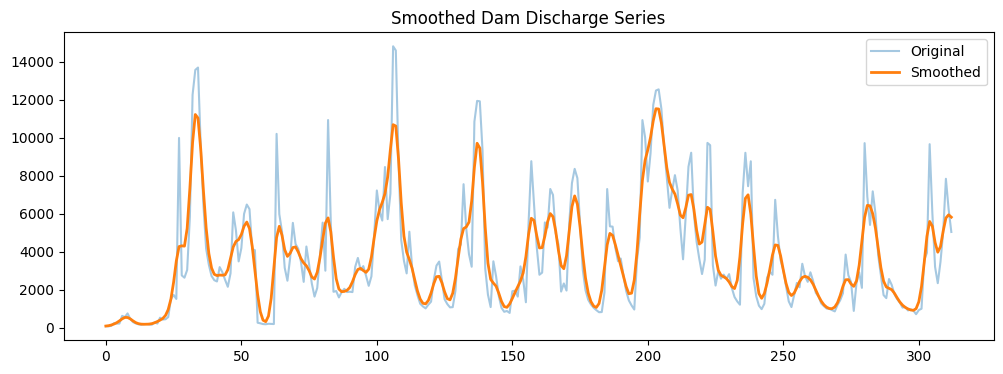

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d

# Assume df['y'] is your discharge series
values = df['y'].astype(float).values

# Gaussian smoothing (gentler than rolling)
df['y_smooth'] = gaussian_filter1d(values, sigma=1.5)

plt.figure(figsize=(12,4))
plt.plot(df['y'], alpha=0.4, label='Original')
plt.plot(df['y_smooth'], label='Smoothed', linewidth=2)
plt.title("Smoothed Dam Discharge Series")
plt.legend()
plt.show()

# Replace with smoothed version for training
values = df['y_smooth'].values


In [6]:
WINDOW_SIZE = 8   # increased context for more accuracy
X, y_vals = [], []
for i in range(WINDOW_SIZE, len(values)):
    X.append(values[i-WINDOW_SIZE:i])
    y_vals.append(values[i])

X, y_vals = np.array(X), np.array(y_vals).reshape(-1, 1)
print("Windowed shape:", X.shape)

# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_vals)

# Split train/val (time-aware)
split_idx = int(len(X_scaled) * 0.8)
X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Windowed shape: (305, 8)
Train samples: 244, Validation samples: 61


In [7]:
# 4 Optimized KAN Model Training
import torch
from neuralforecast.models import KAN
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# More expressive KAN
kan_model = KAN(
    input_size=WINDOW_SIZE,
    hidden_size=64,     # doubled capacity
    h=1,
    activation='relu',
    device=device
).to(device)

optimizer = torch.optim.AdamW(kan_model.parameters(), lr=0.003, weight_decay=1e-4)
loss_fn = torch.nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1).to(device)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).to(device)

train_input = {"insample_y": X_train_t, "futr_exog": None, "hist_exog": None, "stat_exog": None}
val_input   = {"insample_y": X_val_t, "futr_exog": None, "hist_exog": None, "stat_exog": None}

# Training Loop
EPOCHS, PATIENCE = 400, 40
best_val = float('inf')
train_losses, val_losses = [], []

for epoch in trange(EPOCHS):
    kan_model.train()
    optimizer.zero_grad()
    y_pred = kan_model(train_input).squeeze(-1).squeeze(-1).reshape(y_train_t.shape)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(kan_model.parameters(), 5.0)
    optimizer.step()

    kan_model.eval()
    with torch.no_grad():
        y_val_pred = kan_model(val_input).squeeze(-1).squeeze(-1).reshape(y_val_t.shape)
        val_loss = loss_fn(y_val_pred, y_val_t)

    scheduler.step(val_loss)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss.item() < best_val:
        best_val = val_loss.item()
        best_state = {k: v.cpu().clone() for k, v in kan_model.state_dict().items()}

kan_model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


INFO:lightning_fabric.utilities.seed:Seed set to 1


Device: cpu


100%|██████████| 400/400 [00:08<00:00, 48.84it/s]


<All keys matched successfully>


📊 Model Evaluation:
MAE  = 216.77
RMSE = 264.03
MAPE = 11.04%


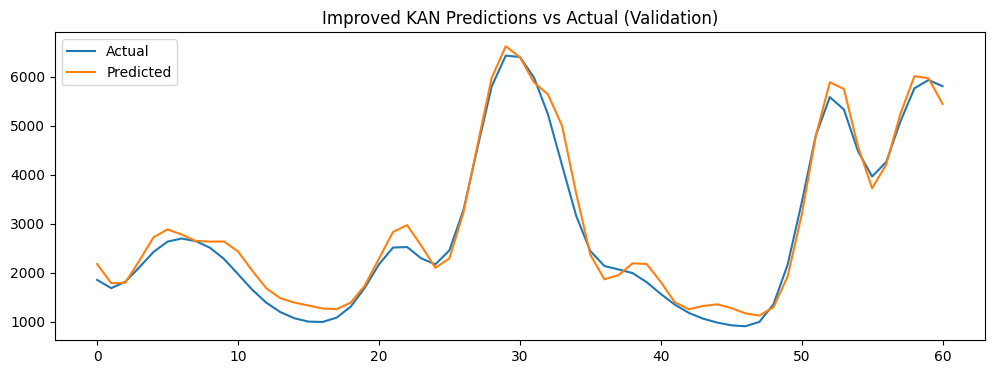

In [8]:
kan_model.eval()
with torch.no_grad():
    y_val_pred_scaled = kan_model(val_input).squeeze(-1).cpu().numpy().reshape(-1, 1)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).squeeze()
y_val_actual = scaler_y.inverse_transform(y_val_t.cpu().numpy().reshape(-1,1)).squeeze()

mae = mean_absolute_error(y_val_actual, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
mape = np.mean(np.abs((y_val_actual - y_val_pred)/(np.abs(y_val_actual)+1e-8))) * 100

print(f"\n📊 Model Evaluation:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

# Plot
plt.figure(figsize=(12,4))
plt.plot(y_val_actual, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title("Improved KAN Predictions vs Actual (Validation)")
plt.legend()
plt.show()


In [9]:
# ===========================
# FIXED FINAL CELL: DARK MODE UI with robust error display
# ===========================

!pip install -q gradio pillow

import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
import torch
import io
from PIL import Image
import traceback

# Robust prediction wrapper that tolerates different model return shapes
def predict_next_day_safe(past8):
    try:
        past8 = np.array(past8, dtype=float).reshape(1, -1)  # (1,8)

        # Try scaling (if scaler_X exists)
        if 'scaler_X' in globals():
            scaled = scaler_X.transform(past8)   # (1,8)
        else:
            scaled = past8

        # Convert to tensor (1,8,1)
        x_tensor = torch.tensor(scaled, dtype=torch.float32).unsqueeze(-1).to(device)

        input_dict = {
            "insample_y": x_tensor,
            "futr_exog": None,
            "hist_exog": None,
            "stat_exog": None
        }

        kan_model.eval()
        with torch.no_grad():
            raw_out = kan_model(input_dict)

        # Convert raw_out to numpy safely
        try:
            out_np = raw_out.cpu().numpy()
        except Exception:
            # maybe returned a list/tuple or plain tensor, try to handle those
            try:
                out_np = np.asarray(raw_out)
            except Exception:
                # fallback: convert to float if possible
                out_np = np.array([float(raw_out)])

        # Flatten and pick first predicted value
        out_flat = np.array(out_np).ravel()
        if out_flat.size == 0:
            raise ValueError("Model returned empty output.")
        pred_scaled = float(out_flat[0])

        # If scaler_y exists, inverse transform
        if 'scaler_y' in globals():
            try:
                # scaler_y expects 2D array
                pred = scaler_y.inverse_transform(np.array(pred_scaled).reshape(-1,1))[0][0]
            except Exception:
                # fallback if weird shape
                pred = float(pred_scaled)
        else:
            pred = float(pred_scaled)

        return float(pred), None

    except Exception as e:
        # Return None plus full traceback string for UI display
        tb = traceback.format_exc()
        return None, tb

# Plot as PIL image so Gradio displays reliably
def make_plot_pil(past8, prediction):
    try:
        days = list(range(1, 9))
        future_day = [9]

        plt.style.use("dark_background")
        fig, ax = plt.subplots(figsize=(8,4))

        ax.plot(days, past8, marker="o", linewidth=2, color="#3b82f6", label="Past 8 days")
        ax.scatter(future_day, [prediction], color="#ef4444", s=100, label="Predicted Day 9")
        ax.plot(days + future_day, list(past8) + [prediction], linestyle="--", alpha=0.7, color="white")
        ax.set_title("Discharge Trend")
        ax.set_xlabel("Day")
        ax.set_ylabel("Discharge (m³/s)")
        ax.grid(alpha=0.25)
        ax.legend(loc='best')

        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=120)
        buf.seek(0)
        plt.close(fig)
        img = Image.open(buf).convert("RGB")
        return img
    except Exception:
        return None

# Alert generator (keeps same visible styling)
def generate_alert_html(pred, last):
    try:
        change = ((pred - last) / (last + 1e-6)) * 100
        if change > 25:
            return "<div class='alert-box alert-red'>⚠️ High discharge rise predicted!</div>"
        elif change > 10:
            return "<div class='alert-box alert-yellow'>⚠️ Moderate increase — monitor upstream</div>"
        else:
            return "<div class='alert-box alert-green'>✓ Stable — no immediate action</div>"
    except Exception:
        return "<div class='alert-box alert-yellow'>⚠️ Cannot compute alert (invalid inputs)</div>"

# Main UI function that returns clear error messages if anything goes wrong
def ui_predict_safe(d1,d2,d3,d4,d5,d6,d7,d8):
    past = [d1,d2,d3,d4,d5,d6,d7,d8]
    # Basic validation
    try:
        if any([v is None for v in past]):
            return ("ERROR: Please fill all 8 day values.",
                    "<div class='alert-box alert-yellow'>Incomplete input</div>",
                    None)
        if any([ (isinstance(v, (int,float)) and (v < 0)) for v in past]):
            # negative discharge not allowed
            return ("ERROR: Discharge values must be non-negative.",
                    "<div class='alert-box alert-yellow'>Invalid input</div>",
                    None)
    except Exception as e:
        return (f"ERROR validating inputs: {e}", "<div class='alert-box alert-red'>Validation failed</div>", None)

    # Predict
    pred, err = predict_next_day_safe(past)
    if err is not None:
        # show full error trace in summary to help debugging
        summary = "PREDICTION FAILED — see error details below:\n\n" + err
        return (summary, "<div class='alert-box alert-red'>❌ Prediction error</div>", None)

    # If pred is None for some reason
    if pred is None:
        return ("ERROR: Model returned no prediction.", "<div class='alert-box alert-red'>❌ No output</div>", None)

    # Generate outputs
    try:
        alert_html = generate_alert_html(pred, past[-1])
    except Exception:
        alert_html = "<div class='alert-box alert-yellow'>⚠️ Could not compute alert</div>"

    summary = (
        f"Predicted Next-Day Discharge: {pred:.3f} m³/s\n"
        f"Change vs Day 8: {(pred - past[-1]):.3f} m³/s"
    )

    plot_img = make_plot_pil(past, pred)

    return (summary, alert_html, plot_img)

# DARK MODE UI (same style, robust)
with gr.Blocks(theme=gr.themes.Soft(), css="""
body { background: #0D1117 !important; color: #E6EDF3 !important; }
.header { background: #1F6FEB; padding: 20px; font-size: 28px; font-weight: bold; text-align: center; color: white; border-radius: 0 0 10px 10px; }
.card { background: #161B22; padding: 20px; border-radius: 12px; box-shadow: 0 0 12px rgba(0,0,0,0.6); border:1px solid #30363D; }
.section-title { color: #58A6FF; font-size: 18px; font-weight:600; margin-bottom:8px; }
.alert-box { padding: 12px; margin-top: 10px; border-radius: 8px; font-weight:600; }
.alert-green { background: rgba(0,255,150,0.12); color: #4ADE80; border:1px solid #4ADE80; }
.alert-yellow { background: rgba(255,200,0,0.12); color: #FACC15; border:1px solid #FACC15; }
.alert-red { background: rgba(255,70,70,0.12); color: #F87171; border:1px solid #F87171; }
""") as demo:

    gr.HTML("<div class='header'>Hydropower Discharge Prediction — UI (Robust)</div>")

    with gr.Row():
        with gr.Column(scale=1):
            with gr.Group(elem_classes="card"): # Changed gr.Box to gr.Group
                gr.HTML("<div class='section-title'>Enter Past 8 Days (m³/s)</div>")
                d1 = gr.Number(label="Day 1", value=0.0)
                d2 = gr.Number(label="Day 2", value=0.0)
                d3 = gr.Number(label="Day 3", value=0.0)
                d4 = gr.Number(label="Day 4", value=0.0)
                d5 = gr.Number(label="Day 5", value=0.0)
                d6 = gr.Number(label="Day 6", value=0.0)
                d7 = gr.Number(label="Day 7", value=0.0)
                d8 = gr.Number(label="Day 8", value=0.0)
                btn = gr.Button("Predict Next Day", variant="primary")

        with gr.Column(scale=2):
            with gr.Group(elem_classes="card"): # Changed gr.Box to gr.Group
                summary = gr.Textbox(label="Prediction Summary / Errors", lines=6)
                alert_box = gr.HTML()
                plot = gr.Image(label="Trend Chart (click to enlarge)")

    btn.click(ui_predict_safe, inputs=[d1,d2,d3,d4,d5,d6,d7,d8], outputs=[summary, alert_box, plot])

demo.launch()


/tmp/ipython-input-3141268914.py:159: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), css="""
/tmp/ipython-input-3141268914.py:159: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), css="""


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://277f957827d9407e0a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
